<a href="https://colab.research.google.com/github/Davidportlouis/horse_vs_human_classifier/blob/master/horses_vs_humans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import numpy as np
from PIL import Image
from torch import nn,optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms,datasets,models
from torch.utils.data.sampler import SubsetRandomSampler
from helper import plot_batch,train,test,predict,predict_image

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O horse-or-human.zip
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O validation-horse-or-human.zip 
!unzip "horse-or-human.zip" -d "./data/train"
!unzip "validation-horse-or-human.zip" -d "./data/valid/"

--2020-06-28 03:03:09--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M   243MB/s    in 0.6s    

2020-06-28 03:03:10 (243 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]

--2020-06-28 03:03:12--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 

In [4]:
train_transform = transforms.Compose([
  transforms.Resize(299),
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  transforms.RandomRotation(45),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485,0.456,0.406],
                       std=[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
  transforms.Resize(150),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485,0.456,0.406],
                       std=[0.229,0.224,0.225])
])

train_data = datasets.ImageFolder("./data/train",transform=train_transform)
test_data = datasets.ImageFolder("./data/valid",transform=test_transform)

train_len = len(train_data)
idx = list(range(train_len))
np.random.shuffle(idx)
split = int(np.floor(0.2 * train_len))
valid_idx,train_idx = idx[:split],idx[split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data,batch_size=20,sampler=train_sampler)
valid_loader = DataLoader(train_data,batch_size=20,sampler=valid_sampler)
test_loader = DataLoader(test_data,batch_size=20,shuffle=True)
classes = train_data.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

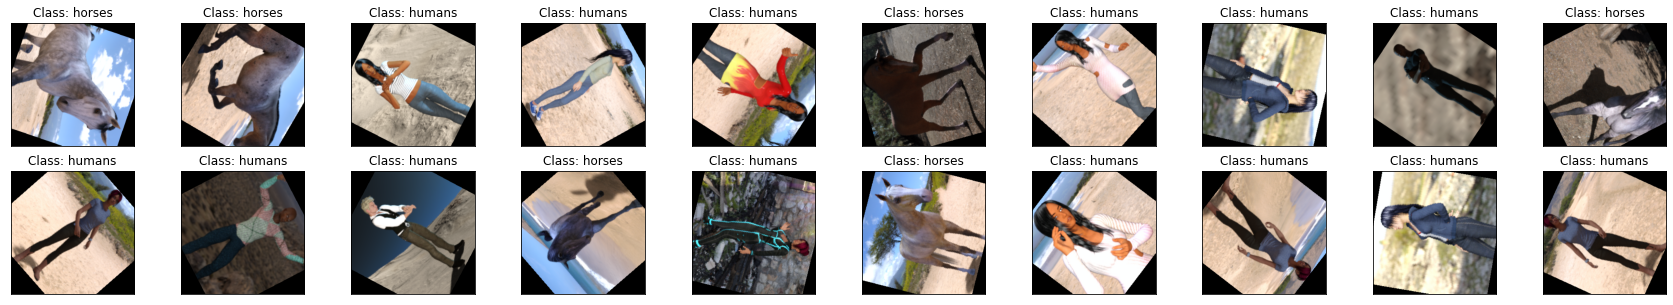

In [44]:
train_images,train_labels = next(iter(train_loader))
plot_batch(train_images,classes,train_labels,normalize=True)

In [29]:
model = models.inception_v3(pretrained=True,aux_logits=False)

In [30]:
for params in model.parameters():
  params.require_grad = False

In [31]:
fc = nn.Sequential(
    nn.Linear(2048,512),
    nn.ReLU(),
    nn.Linear(512,2)
)
model.fc = fc

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=0.01)

In [33]:
train_losses,valid_losses = train(model,train_loader,valid_loader,optimizer,criterion,10,device)

epoch: 1/10 trainloss: 1.44849 validloss: 0.05911 time: 811.132 sec
Loss decresed: inf -> 0.05911
epoch: 2/10 trainloss: 0.18006 validloss: 0.03412 time: 783.806 sec
Loss decresed: 0.05911 -> 0.03412
epoch: 3/10 trainloss: 0.22257 validloss: 0.04466 time: 780.517 sec
epoch: 4/10 trainloss: 0.17223 validloss: 0.08586 time: 780.873 sec


KeyboardInterrupt: ignored

In [35]:
state_dict = torch.load("model_weights.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [36]:
test(model,test_loader,optimizer,criterion,device)

testloss: 0.159058 accuracy: 0.945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

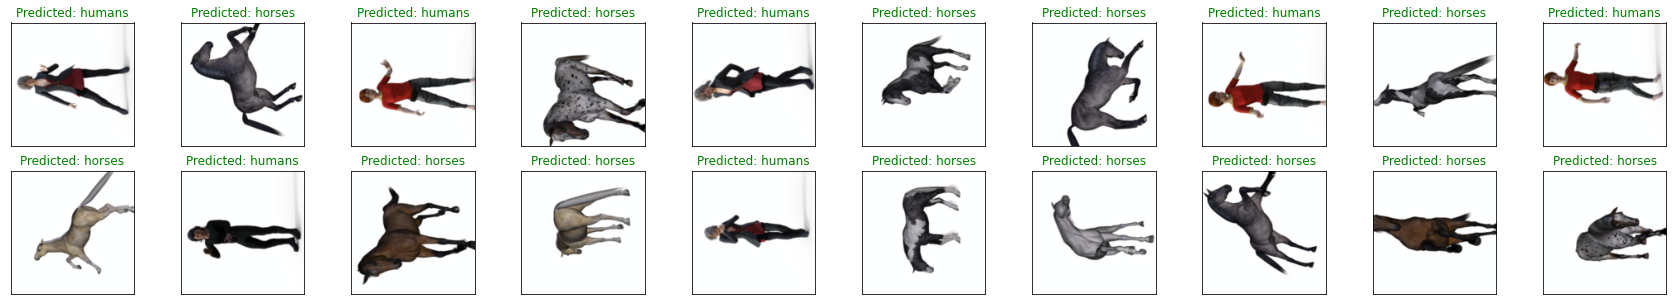

In [41]:
test_images,test_labels = next(iter(test_loader))
predict(test_images,classes,test_labels,model,device)

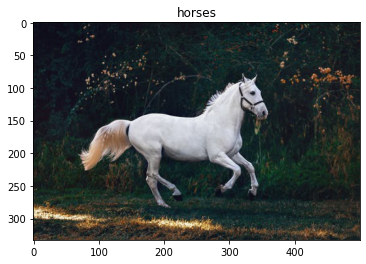

In [42]:
predict_image("t1_horse.jpeg",model,test_transform,device,classes)

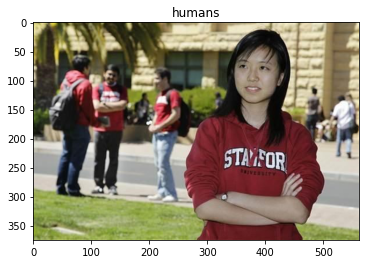

In [43]:
predict_image("t2_human.jpg",model,test_transform,device,classes)